# Validating Conditional Normalizing Flows
I trained 3 separate normaling flows: 
1. $P(X,Y)$
2. $P(Y)$
3. $P(X|Y)$

where $Y$ is the central pixels of the MNIST data set and $X$ are the rest of the pixels. I will denote the normalizing flows estimate of the PDFs as $\hat{P}$.

Afterwards, I used the normalizing flows to:
1. sample $Y' \sim \hat{P}(Y)$
2. sample $X' \sim \hat{P}(X|Y')$
3. transform $(X', Y')$ to $Z'$ using the normaling flow for $\hat{P}(X|Y)$

If CNF is working correctly, $p(Z')$ should be $\mathcal{N}(0, 1)$

In [1]:
import os 
import numpy as np 
import corner as DFM 
import matplotlib.pyplot as plt 

# read in CNF samples

In [2]:
dat_dir = '/Users/chahah/data/arcoiris/'
Zp = np.load(os.path.join(dat_dir, 'Zp.npy'))

In [3]:
prng_norm = np.random.normal(size=10000)

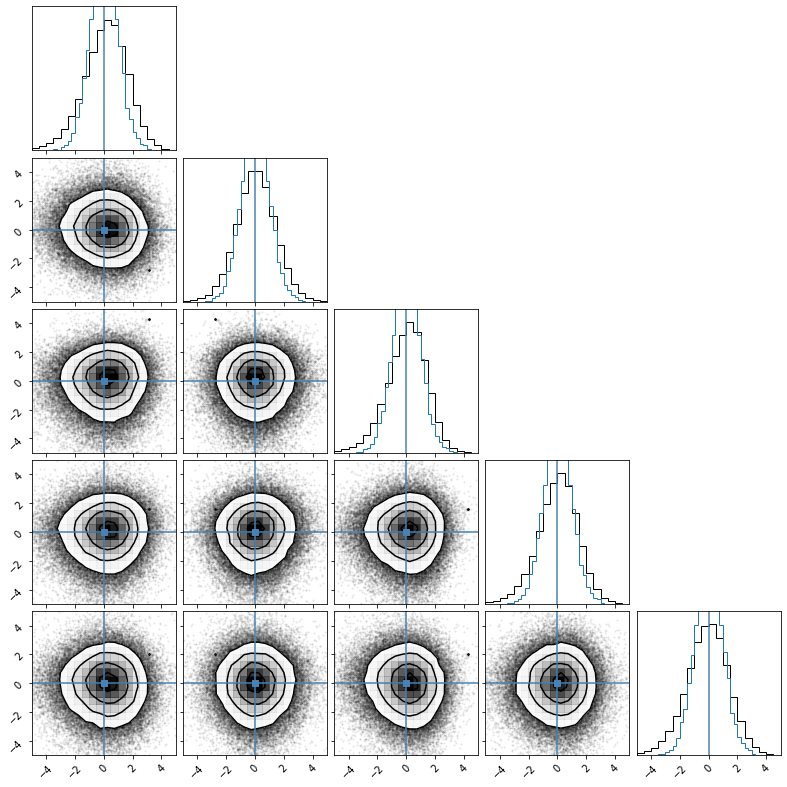

In [4]:
ndim = 5
fig = DFM.corner(Zp[:,:ndim], 
                 range=[(-5, 5) for i in range(ndim)], 
                 truths=np.zeros(ndim), 
                 hist_kwargs={"density": True})

axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    _ = ax.hist(prng_norm, density=True, color='C0', range=(-5, 5), bins=40, histtype='step')

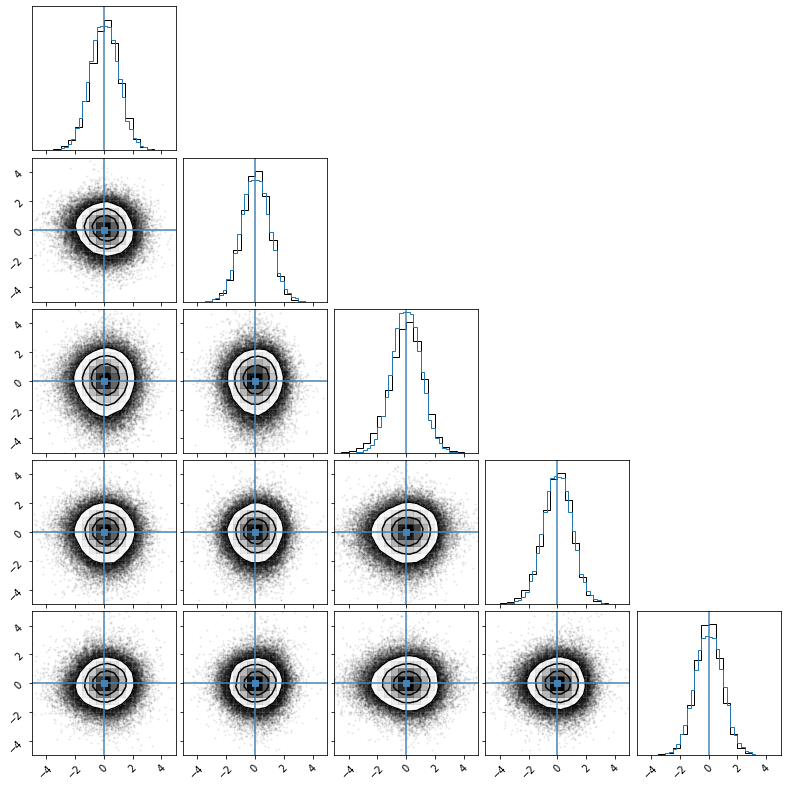

In [5]:
ndim = 5
fig = DFM.corner(Zp[:,-ndim:], 
                 range=[(-5, 5) for i in range(ndim)], 
                 truths=np.zeros(ndim), 
                 hist_kwargs={"density": True})

axes = np.array(fig.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    _ = ax.hist(prng_norm, density=True, color='C0', range=(-5, 5), bins=40, histtype='step')

(-5.0, 5.0)

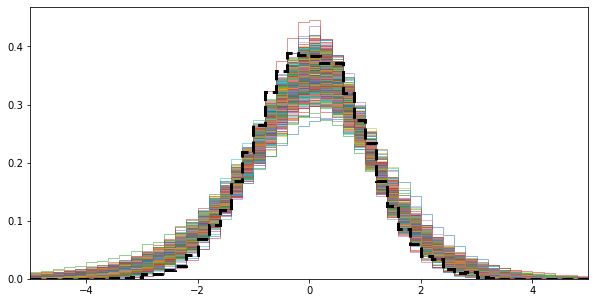

In [6]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for i in range(Zp.shape[1]):
    _ = sub.hist(Zp[:,i], density=True, range=(-5, 5), bins=50, linewidth=0.5, color='C%i' % i, histtype='step')
_ = sub.hist(prng_norm, density=True, range=(-5, 5), bins=50, linewidth=3, linestyle='--', color='k', histtype='step')
sub.set_xlim(-5, 5)

Close to $\mathcal{N}(0, 1)$, but a bit skewed and broader...

# $D_{\rm KL} (p(Z') || \mathcal{N}(0,1))$


In [17]:
from scipy.linalg import sqrtm
from scipy.special import digamma
from sklearn.neighbors import KDTree
import faiss
import time

In [8]:
def KL_w2009_eq5(X, Y, k=5): 
    ''' kNN KL divergence estimate using Eq. 5 from Wang et al. (2009)  

    sources 
    ------- 
    - Q. Wang, S. Kulkarni, & S. Verdu (2009). Divergence Estimation for Multidimensional Densities Via k-Nearest-Neighbor Distances. IEEE Transactions on Information Theory, 55(5), 2392-2405.
    '''
    d, n, m = XY_dim(X, Y)

    
    index_X = faiss.IndexFlatL2(d)
    index_X.add(X.astype('float32'))
    
    index_Y = faiss.IndexFlatL2(d)
    index_Y.add(Y.astype('float32'))
    
    # first determine epsilon(i)
    dNN_XX, _ = index_X.search(X.astype('float32'), k=k+1)
    dNN_XY, _ = index_Y.search(X.astype('float32'), k=k)
    
    rho_i = dNN_XX[:,-1]
    nu_i = dNN_XY[:,-1]
    return float(d)/float(n) * np.sum(np.log(nu_i / rho_i)) + np.log(float(m)/float(n - 1))


def KL_faiss(X, Y):
    ''' kNN KL divergence estimate using Eq. 29 from Wang et al. (2009). 
    This has some bias reduction applied to it and a correction for 
    epsilon.

    sources 
    ------- 
    - Q. Wang, S. Kulkarni, & S. Verdu (2009). Divergence Estimation for Multidimensional Densities Via k-Nearest-Neighbor Distances. IEEE Transactions on Information Theory, 55(5), 2392-2405.
    '''
    d, n, m = XY_dim(X, Y)

    index_X = faiss.IndexFlatL2(d)
    index_X.add(X.astype('float32'))
    
    index_Y = faiss.IndexFlatL2(d)
    index_Y.add(Y.astype('float32'))
    
    tree_X = KDTree(X)
    tree_Y = KDTree(Y)
    
    # first determine epsilon(i)
    dNN_XX, _ = index_X.search(X.astype('float32'), k=2)
    dNN_XY, _ = index_Y.search(X.astype('float32'), k=1)
    eps = np.amax([np.sqrt(dNN_XX[:,1]), np.sqrt(dNN_XY[:,0])], axis=0) * 1.000001
    
    # find l_i and k_i
    i_l = tree_X.query_radius(X, eps)
    i_k = tree_Y.query_radius(X, eps)
    l_i = np.array([len(il)-1 for il in i_l])
    k_i = np.array([len(ik) for ik in i_k])
    assert l_i.min() > 0
    assert k_i.min() > 0
    
    rho_i = np.empty(n, dtype=float)
    nu_i = np.empty(n, dtype=float)
    for _k in range(1,np.max([l_i.max(), k_i.max()])+1): 
        l_i_k = (l_i == _k)
        k_i_k = (k_i == _k)
        
        if np.sum(l_i_k) > 0: 
            rho_ii, _ = index_X.search(X[l_i_k,:].astype('float32'), k=_k+1)
            rho_i[l_i_k] = rho_ii[:,-1]
        if np.sum(k_i_k) > 0: 
            nu_ii, _ = index_Y.search(X[k_i_k,:].astype('float32'), k=_k)
            nu_i[k_i_k] = nu_ii[:,-1]
    rho_i = np.sqrt(rho_i)
    nu_i = np.sqrt(nu_i)
    
    d_corr = float(d) / float(n) * np.sum(np.log(nu_i/rho_i))
    return d_corr + np.sum(digamma(l_i) - digamma(k_i)) / float(n) + np.log(float(m)/float(n-1))

def KL_w2009_eq29(X, Y):
    ''' kNN KL divergence estimate using Eq. 29 from Wang et al. (2009). 
    This has some bias reduction applied to it and a correction for 
    epsilon.

    sources 
    ------- 
    - Q. Wang, S. Kulkarni, & S. Verdu (2009). Divergence Estimation for Multidimensional Densities Via k-Nearest-Neighbor Distances. IEEE Transactions on Information Theory, 55(5), 2392-2405.
    '''
    d, n, m = XY_dim(X, Y)

    tree_X = KDTree(X)
    tree_Y = KDTree(Y)
    
    # first determine epsilon(i)
    dNN_XX, _ = tree_X.query(X, k=2)
    dNN_XY, _ = tree_Y.query(X, k=1)
    eps = np.amax([dNN_XX[:,1], dNN_XY[:,0]], axis=0) * 1.000001
    
    # find l_i and k_i
    i_l = tree_X.query_radius(X, eps)
    i_k = tree_Y.query_radius(X, eps)
    l_i = np.array([len(il)-1 for il in i_l])
    k_i = np.array([len(ik) for ik in i_k])
    assert l_i.min() > 0
    assert k_i.min() > 0
    
    rho_i = np.empty(n, dtype=float)
    nu_i = np.empty(n, dtype=float)
    for _k in range(1,np.max([l_i.max(), k_i.max()])+1): 
        l_i_k = (l_i == _k)
        k_i_k = (k_i == _k)
        
        if np.sum(l_i_k) > 0: 
            rho_ii, _ = tree_X.query(X[l_i_k,:], k=_k+1)
            rho_i[l_i_k] = rho_ii[:,-1]
        if np.sum(k_i_k) > 0: 
            nu_ii, _ = tree_Y.query(X[k_i_k,:], k=_k)
            nu_i[k_i_k] = nu_ii[:,-1]

    d_corr = float(d) / float(n) * np.sum(np.log(nu_i/rho_i))
    return d_corr + np.sum(digamma(l_i) - digamma(k_i)) / float(n) + np.log(float(m)/float(n-1))


def XY_dim(X, Y): 
    assert X.shape[1] == Y.shape[1]
    d = X.shape[1] # dimensions
    n = X.shape[0] # X sample size
    m = Y.shape[0] # Y sample size
    return d, n, m 

In [14]:
Z_p = Zp[np.all(np.isfinite(Zp), axis=1)][::50,:]
X_p = np.random.multivariate_normal(np.zeros(Zp.shape[1]), np.eye(Zp.shape[1]), size=Z_p.shape[0])

In [20]:
Dkl_Z, Dkl_X = [], [] 
for i in range(20): 
    Z_p = Zp = np.load(os.path.join(dat_dir, 'Zp.%i.npy' % i))
    Z_p = Z_p[np.all(np.isfinite(Z_p), axis=1)]
    X_p = np.random.multivariate_normal(np.zeros(Z_p.shape[1]), np.eye(Z_p.shape[1]), size=Z_p.shape[0])
    
    Z_ref = np.random.multivariate_normal(np.zeros(Zp.shape[1]), np.eye(Zp.shape[1]), size=int(1e4))

    #_Dkl_Z = KL_w2009_eq5(Z_ref, Z_p, k=5)
    #_Dkl_X = KL_w2009_eq5(Z_ref, X_p, k=5)
    _Dkl_Z = KL_faiss(Z_ref, Z_p)
    _Dkl_X = KL_faiss(Z_ref, X_p)
    Dkl_Z.append(_Dkl_Z)
    Dkl_X.append(_Dkl_X)

KeyboardInterrupt: 

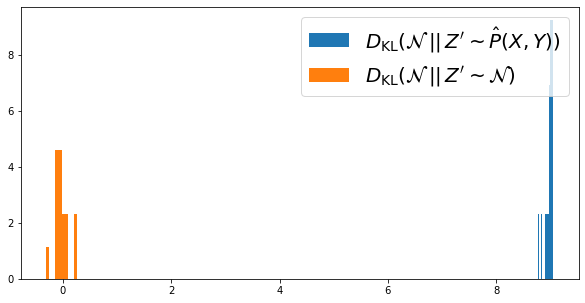

In [21]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
_ = sub.hist(Dkl_Z, density=True, label=r"$D_{\rm KL}(\mathcal{N}\,||\,Z'\sim \hat{P}(X,Y))$")
_ = sub.hist(Dkl_X, density=True, label=r"$D_{\rm KL}(\mathcal{N}\,||\,Z'\sim \mathcal{N})$")
sub.legend(loc='upper right', fontsize=20)